# inspect llc parcel simulation

In [1]:
import os, shutil
import glob

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import xgcm

from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile
#from parcels import FieldSet, ParticleFile, plotTrajectoriesFile
#from mitequinox.particleset import ParticleSet
from parcels import JITParticle, ScipyParticle
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#cluster = LocalCluster(processes=False, n_workers=4, threads_per_worker=2)
#
from dask_jobqueue import PBSCluster
# ** processes and cores may be adjusted in order to have more memory or inversely more computational ressource
#cluster = PBSCluster(processes=5, cores=5, walltime='04:00:00')
#cluster = PBSCluster(walltime='04:00:00')
cluster = PBSCluster()
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.219:51831 Dashboard: http://10.148.0.219:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## setup directories and run parameters

In [3]:
#root_dir = '/home1/scratch/aponte/parcels/'
#root_dir = '/home1/dunree/slgentil/tmp/parcels/'
root_dir = '/home1/datawork/slgentil/parcels/'

#run_name = "test1"
#run_name = 'test2'
#run_name = 'test3'
#run_name = 'test4'
run_name = 'global_T365j_dt1j_dij50'

run_dir = root_dir+run_name

In [4]:
# not working pickle issue

#tile_dir = os.path.join(run_dir,'tiling/')

#tl = pa.tiler(tile_dir=tile_dir)    
#tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
#                  for t in range(tl.N_tiles)
#                 ]

In [5]:
# simulation parameters

#T = 360? # length of the total run [days]
T = 20 # ** debug
#dt_windows = 5 # time window
dt_windows = 2 # ** debug, 5j devrait être plus approprié je pense
dt_stepping = 1 # hours
dt_outputs = 1 # hours

dij_init = 10 # initial position subsampling compared to llc grid

---

## load llc data

In [6]:
%%time
if False:
    # load llc data
    ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
    grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
    ds = xr.merge([ds, grd])
    ds

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


---

## create tiles - !!! should be deleted eventually

This could be done somewhere else, in another notebook

See `rearrange.ipynb` and `tile.ipynb` for more details

** Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant

In [7]:
%%time

create_tiles = False

tile_dir = os.path.join(run_dir,'tiling/')
#tile_dir = '/home1/scratch/aponte/parcels/tile_tmp/'
if create_tiles:
    
    # ** could filter out tiles that are empty, criterium on Depth or SST should be sufficient

    # create tiler
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(10, 10), overlap=(100, 100))
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 20), overlap=(100, 100))
    tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(100, 100))
    # store tiler
    tl.store(tile_dir)
    
else:
    
    #tile_dir = ut.root_data_dir+'parcels/tiling/'
    #tile_dir = os.path.join(run_dir,'tiling/')
    tl = pa.tiler(tile_dir=tile_dir)
    
tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
                  for t in range(tl.N_tiles)
                 ]

CPU times: user 432 ms, sys: 56 ms, total: 488 ms
Wall time: 482 ms


---
## load dataset and plot a subset of trajectories

In [8]:
float_files = []
for _dir in tile_data_dirs:
    float_files.extend(sorted(glob.glob(_dir+"/floats_*.nc")))
    #float_files.extend(sorted(glob.glob(_dir+"/floats_364*.nc")))
print(float_files[:5])
print(float_files[-5:])

['/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_001/floats_000_001.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_001/floats_001_001.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_001/floats_002_001.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_001/floats_003_001.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_001/floats_004_001.nc']
['/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_024/floats_360_024.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_024/floats_361_024.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_024/floats_362_024.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_024/floats_363_024.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_024/floats_364_024.nc']


In [9]:
def xr2df(file):
    return xr.open_dataset(file).to_dataframe().set_index('trajectory')

lazy_dataframes = [delayed(xr2df)(f) for f in float_files]

In [10]:
%%time
_df = lazy_dataframes[0].compute()

CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 2.34 s


In [11]:
%%time
df = dd.from_delayed(lazy_dataframes, meta=_df)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 25 ms


In [12]:
%%time
df_pd = df.compute() # load in notebook, dangerous !!

CPU times: user 49.8 s, sys: 38 s, total: 1min 27s
Wall time: 2min 28s


In [13]:
print(df_pd['time'].min())
print(df_pd['time'].max())

2011-11-15 00:00:00
2012-11-14 01:00:00


## Find lost trajectories

In [14]:
%%time
df_gb = df_pd.groupby([df_pd.index])
df_ct = df_gb.count()
df_ct

CPU times: user 21.7 s, sys: 3.59 s, total: 25.3 s
Wall time: 25 s


,time,lat,lon,z
trajectory,,,,
1000000.0,1560,1560,1560,1560
1000001.0,9490,9490,9490,9490
1000002.0,9490,9490,9490,9490
1000003.0,9490,9490,9490,9490
1000004.0,9490,9490,9490,9490
...,...,...,...,...
24001561.0,9490,9490,9490,9490
24001562.0,9490,9490,9490,9490
24001563.0,9490,9490,9490,9490


In [15]:
nbtimes = df_ct['time'].max()
print(nbtimes)
dlost = df_ct[df_ct['time'] != nbtimes].index
#dlost = df_ct[df_ct['time'] < 97].index
print(f'Nombre de flotteurs perdus: {dlost.size:5d} ({dlost.size/len(df_ct.index):%})')
dlost

9490
Nombre de flotteurs perdus:  8871 (17.753717%)


Float64Index([ 1000000.0,  1000051.0,  1000074.0,  1000102.0,  1000153.0,
               1000204.0,  1000205.0,  1000255.0,  1000294.0,  1000306.0,
              ...
              24001509.0, 24001510.0, 24001514.0, 24001533.0, 24001535.0,
              24001545.0, 24001550.0, 24001552.0, 24001560.0, 24001565.0],
             dtype='float64', name='trajectory', length=8871)

## Plot last position of lost floats

In [16]:
%%time
_d = df_pd[df_pd.index.isin(dlost)]
_d = _d.groupby('trajectory').last()
#_d = _d[_d['time'].dt.hour==1]
#_d = _d[_d['time'] == pd.Timestamp(2011,11,16,1)]
#_d = _d[(_d['lon']>-40) & (_d['lon']<-30) & (_d['lat']>-40) & (_d['lat']<20)]

print(_d)
gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

                          time        lat        lon    z
trajectory                                               
1000000.0  2012-01-14 01:00:00 -71.930735 -38.526908  0.0
1000051.0  2012-01-20 01:00:00 -71.960066 -34.413193  0.0
1000074.0  2012-02-01 01:00:00 -59.012785 -26.600780  0.0
1000102.0  2012-01-20 01:00:00 -71.943650 -36.608227  0.0
1000153.0  2012-02-15 01:00:00 -71.977897 -36.497171  0.0
...                        ...        ...        ...  ...
24001545.0 2011-11-21 01:00:00  57.578132 -35.009414  0.0
24001550.0 2011-11-20 01:00:00  59.769384 -35.267590  0.0
24001552.0 2011-11-24 01:00:00  61.065363 -35.092453  0.0
24001560.0 2011-12-30 01:00:00  59.595141 -35.366415  0.0
24001565.0 2012-07-21 01:00:00  65.776164 -36.409511  0.0

[8871 rows x 4 columns]
CPU times: user 1min 12s, sys: 10.9 s, total: 1min 23s
Wall time: 1min 22s


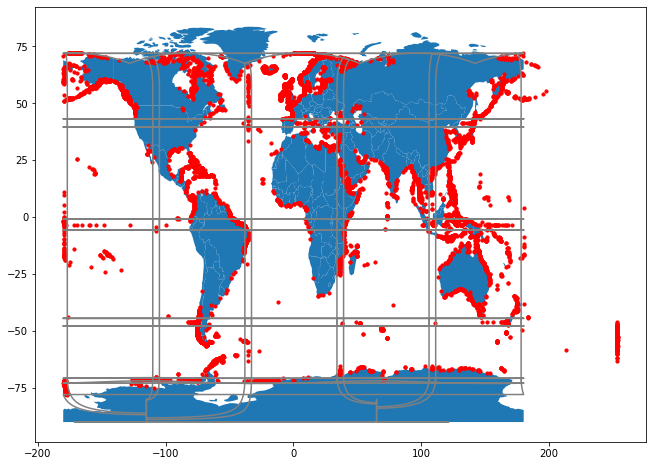

In [17]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='red', markersize=10)
#ax.set_axis_off()
#ax.set_xlim(xmin=-110, xmax=40)
#ax.set_ylim(ymin=-10, ymax=50)
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color="grey")
#for b in tl.G['boundaries']:
#    b.to_crs(crs).boundary.plot(ax=ax, color="red")
#tl.G['boundaries'][3].to_crs(crs).boundary.plot(ax=ax, color="black")  
#tl.G['boundaries'][23].to_crs(crs).boundary.plot(ax=ax, color="red")  
#tl.G['tiles'][3].to_crs(crs).boundary.plot(ax=ax, color="grey")     
#tl.G['tiles'][23].to_crs(crs).boundary.plot(ax=ax, color="grey")  

### plot last time

In [18]:
%%time
_d = df_pd[df_pd['time']==df_pd['time'].max()]
gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

CPU times: user 3.76 s, sys: 1.61 s, total: 5.36 s
Wall time: 5.27 s


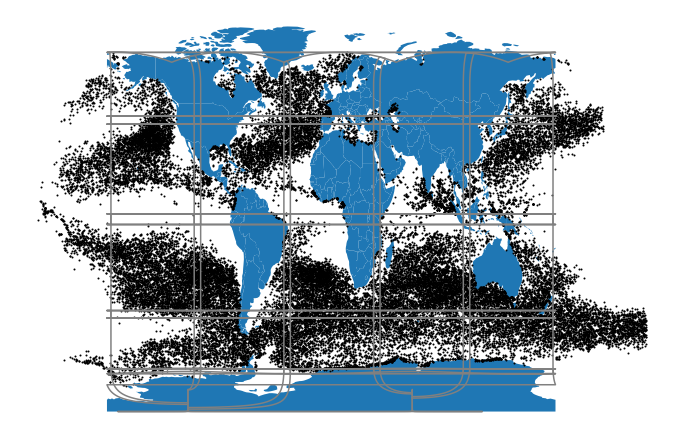

In [19]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='k', markersize=1)
ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

## Plot uncomplete trajectory

In [ ]:
%%time
_d = df_pd[df_pd.index.isin(dlost)]
_d = _d.groupby('trajectory')
keys = list(_d.groups.keys())[::100]
_d = _d.filter(lambda x: x.name in keys)
gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='r', markersize=1)
#ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

## Plot a complete trajectory

In [ ]:
%%time
_dg = df_pd[~df_pd.index.isin(dlost)].groupby('trajectory')
keys = list(_dg.groups.keys())[::1000]
_d = _dg.filter(lambda x: x.name in keys)

gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='r', markersize=0.5)
#ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

## Close cluster

In [ ]:
cluster.close()